# Crawling Tiki main categories and sub categories

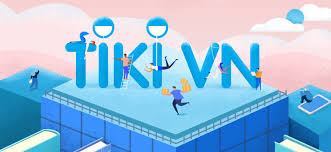

This notebook will guide you to use python function recursively to crawl main categories. For each main categories, it will start to crawl links for sub categories. Recursively, each sub categories have deeper levels of sub categories( Main -> level 2 -> level 3 -> level 4 -> ... ? ) = How deep can it go -> Inception!!!

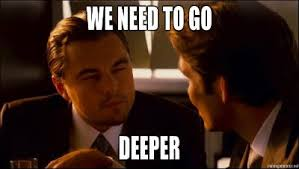

Since we don't know how many level of sub categories and how deep for each categories, we need to use recursion to solve this problem.

All of these category links will be saved in a SQLite database.
After crawling all categories (main and subs), you can use your previous weekly project function to crawl products for each of categories to get to get as many products as possible.

At the end of the day, this notebook only crawl links of categories. Therefore, crawling products is your task for the weekly project.

In [11]:
# install selenium and other resources for crawling data
!pip install selenium
# install other resources for doing crawling
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (89.0.4389.90-0ubuntu0.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
from random import randint
import json
import re

from selenium import webdriver
# Set driver for Chrome
options = webdriver.ChromeOptions()
options.add_argument('-headless') # since we run selenium on Google Colab so we don't want a chrome browser opens, so it will run in the background
options.add_argument('-no-sandbox')

In [3]:
def get_url(url):
  driver = webdriver.Chrome('chromedriver',options=options)        # Define the chrome drivers with setting options we define above    
  driver.get(url)                                             # Open the browser again to get web page
  html_data = driver.page_source                                   # After driver.get() is done, you can get back HTML string by using .page_source
  driver.close()                                                   # Close the driver after retrieving the web page

  soup = BeautifulSoup(html_data, 'html.parser') 

  return soup

In [4]:
def extract_tiki_info(url):
  """ Extract info from all products of a specfic category on Tiki website
      Input: url
      Output: info of products, saved as list of dictionary. If no products shown, return empty list.
  """
  data = []
  index = 1
  soup = get_url(url)

  # FIND ALL PRODUCT ITEMS
  products = soup.find_all('a', {'class':'product-item'})
  all_script = soup.find_all('script', {'type':'application/ld+json'})
  print("BATCH SIZE:", len(products))

  if (soup.find('div', {'class':'style__StyledNotFoundProductView-sc-1uz0b49-0'})):
    print("END PAGE")
  elif len(products):
    # EXTRACT INFO TO DICTIONARY
    for i in products: 
      d = {'name':'','price':'','product_url':'','image':'', 'product_sku':'',
           'tiki_now':'','freeship':'','review':'','rating':'','under_price':'',
           'discount':'','installment':'','gift':''}
      
      try:
        d['name']         = i.find('div',{'class' : 'name'}).text
        d['price']        = int(re.sub('[. ₫]','', i.find('div',{'class':'price-discount__price'}).text))
        d['product_url']  = 'https://tiki.vn' + i['href'] 
        thumbnail         = i.find('div',{'class':'thumbnail'})
        d['image']        = thumbnail.img['src']        
        d['tiki_now']     = bool(i.find('div',{'class':'badge-service'}).find('div',{'class':'item'})) 
        d['freeship']     = bool(i.find('div',{'class':'badge-top'}).text == "Freeship")
        
        if i.find('div',{'class':'review'}):
          d['review']     = int(i.find('div',{'class':'review'}).text.strip('(').strip(')'))
        else:
          d['review'] = "N/A"
        
        d['under_price']  = bool(i.find('div',{'class':'badge-under-price'}).find('div',{'class':'item'}))

        if i.find('div', {'class':'price-discount__discount'}):
          d['discount']   = int(re.sub('[-%]','', i.find('div',{'class':'price-discount__discount'}).text))
        else:
          d['discount']   = "N/A"
        
        d['installment']  = bool(i.find('div',{'class':'badge-benefits'}).img)
        d['gift']         = bool(i.find('div',{'class':'freegift-list'}))

        script = all_script[index]
        dict_content = json.loads(script.text)
        d['product_sku']  = dict_content['sku']
        
        if 'aggregateRating' in dict_content:
          d['rating']     = float(dict_content['aggregateRating']['ratingValue'])
        else:
          d['rating']     = "N/A"

      except Exception as e:
        print(e)

      index += 1
      data.append(d)
        
  return data

In [5]:
def scrape_tiki(base_url):
  result = []
  page_number = 1
  main, opt = base_url.split('?')
  
  while True:
    page = f'?page={page_number}&'
    url = main+page+opt
    print("url =", url)
    data = extract_tiki_info(url)
    if len(data)>0:
      result.extend(data)
    else:
      break
    page_number += 1
    sleep(randint(1,2))

  print("****TOTAL = ",len(result))

  items = pd.DataFrame(data = result, columns = result[0].keys())
  items.to_csv("./result2.csv", index=False)

In [6]:
url = "https://tiki.vn/laptop-may-vi-tinh-linh-kien/c1846?src=c.1846.hamburger_menu_fly_out_banner"
# scrape_tiki(url)

# Function to do CRUD (create/ read/ update/ delete) on database

In [7]:
import sqlite3

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
PATH_TO_DB = '/content/gdrive/MyDrive/1_CoderSchool - Machine learning/Week 2/'

In [10]:
conn = sqlite3.connect(PATH_TO_DB+'tiki.db')
cur = conn.cursor()

In [ ]:
# Create table categories in the database using a function
def create_categories_table():
    query = """
        CREATE TABLE IF NOT EXISTS categories (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name VARCHAR(255),
            url TEXT, 
            parent_id INTEGER, 
            create_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    """
    try:
        cur.execute(query)
        conn.commit()
    except Exception as err:
        print('ERROR BY CREATE TABLE', err)
        
create_categories_table()

In [ ]:
def select_query(query,conn=conn):
    return pd.read_sql_query(query, conn)

In [ ]:
# Insert a row of data to the table categories
query = """
    INSERT INTO categories (name, url, parent_id)
    VALUES (?, ?, ?);
"""

# query="""
#     DELETE FROM categories WHERE id=1;
# """

val = ('Phone','phone.xyz', 5)

try:
    cur.execute(query, val)
    cat_id = cur.lastrowid
    print(cat_id)
    conn.commit()

except Exception as err:
    print('ERROR BY INSERT:', err)

2


In [ ]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at
0,1,Phone-Tablet,https://tiki.vn/dien-thoai-may-tinh-bang/c1789,NaN,2021-04-08 15:16:23
1,2,Phone,phone.xyz,5.0,2021-04-08 15:17:11


In [ ]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

# re-create our category table again
create_categories_table()

In [ ]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at


# OOP to do CRUD (create/ read/ update/ delete) on database

In [ ]:
# Instead of using a function to do CRUD on database,
# creating a class Category is preferred
# attributes: name, url, parent_id
# instance method: save_into_db()
class Category:
    def __init__(self, name, url, parent_id=None, cat_id=None):
        self.cat_id = cat_id
        self.name = name
        self.url = url
        self.parent_id = parent_id

    def __repr__(self):
        return f"ID: {self.cat_id}, Name: {self.name}, URL: {self.url}, Parent: {self.parent_id}"

    def save_into_db(self):
        query = """
            INSERT INTO categories (name, url, parent_id)
            VALUES (?, ?, ?);
        """
        val = (self.name, self.url, self.parent_id)
        try:
            cur.execute(query, val)
            self.cat_id = cur.lastrowid
            conn.commit()
        except Exception as err:
            print('ERROR BY INSERT:', err)


In [ ]:
cat1 = Category('Phone-Tablet', 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789')
cat1.save_into_db()
print(cat1.cat_id)

1


In [ ]:
print(cat1)

ID: 1, Name: Phone-Tablet, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789, Parent: None


In [ ]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at
0,1,Phone-Tablet,https://tiki.vn/dien-thoai-may-tinh-bang/c1789,None,2021-04-08 16:15:29


# Get main categories

In [ ]:
# prepare our categories table again
cur.execute('DROP TABLE categories;')
conn.commit()
create_categories_table()

In [ ]:
# empty our category set
CATEGORY_SET = set()

In [ ]:
def can_add_to_cat_set(cat_name,save=False):
  if cat_name not in CATEGORY_SET:
    if save:
      CATEGORY_SET.add(cat_name)
      print(f'Added "{cat_name}" to CATEGORY_SET')
    return True
  return False


In [ ]:
main_categories = [{'Name': 'Điện Thoại - Máy Tính Bảng', 'URL': 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner'},
{'Name': 'Điện Tử - Điện Lạnh', 'URL': 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner'}, 
{'Name': 'Phụ Kiện - Thiết Bị Số', 'URL': 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner'},
{'Name': 'Laptop - Thiết bị IT', 'URL': 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner'},
{'Name': 'Máy Ảnh - Quay Phim', 'URL': 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner'}, 
{'Name': 'Điện Gia Dụng', 'URL': 'https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner'}, 
{'Name': 'Nhà Cửa Đời Sống', 'URL': 'https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner'}, 
{'Name': 'Hàng Tiêu Dùng - Thực Phẩm', 'URL': 'https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner'}, 
{'Name': 'Đồ chơi, Mẹ & Bé', 'URL': 'https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner'}, 
{'Name': 'Làm Đẹp - Sức Khỏe', 'URL': 'https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner'},
{'Name': 'Thể Thao - Dã Ngoại', 'URL': 'https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner'},
{'Name': 'Xe Máy, Ô tô, Xe Đạp', 'URL': 'https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamburger_menu_fly_out_banner'},
{'Name': 'Hàng quốc tế', 'URL': 'https://tiki.vn/hang-quoc-te/c17166?src=c.17166.hamburger_menu_fly_out_banner'}, 
{'Name': 'Sách, VPP & Quà Tặng', 'URL': 'https://tiki.vn/nha-sach-tiki/c8322?src=c.8322.hamburger_menu_fly_out_banner'}, 
{'Name': 'Voucher - Dịch Vụ - Thẻ Cào', 'URL': 'https://tiki.vn/voucher-dich-vu/c11312?src=c.11312.hamburger_menu_fly_out_banner'}]

In [ ]:
def get_main_category(main_categories,save_db=False):
    result=[]
    for i in main_categories:
        _=can_add_to_cat_set(i['Name'],save_db)

        main_cat = Category(i['Name'],i['URL'])
        if save_db:
            main_cat.save_into_db()
        result.append(main_cat)
    return result

In [ ]:
main_cat_objs = get_main_category(main_categories,save_db=True)

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


In [ ]:
select_query('SELECT * FROM CATEGORIES')

,id,name,url,parent_id,create_at
0,1,Điện Thoại - Máy Tính Bảng,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,None,2021-04-08 16:17:05
1,2,Điện Tử - Điện Lạnh,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,None,2021-04-08 16:17:05
2,3,Phụ Kiện - Thiết Bị Số,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,None,2021-04-08 16:17:05
3,4,Laptop - Thiết bị IT,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,None,2021-04-08 16:17:05
4,5,Máy Ảnh - Quay Phim,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,None,2021-04-08 16:17:05
5,6,Điện Gia Dụng,https://tiki.vn/dien-gia-dung/c1882?src=c.1882...,None,2021-04-08 16:17:05
6,7,Nhà Cửa Đời Sống,https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...,None,2021-04-08 16:17:05
7,8,Hàng Tiêu Dùng - Thực Phẩm,https://tiki.vn/bach-hoa-online/c4384?src=c.43...,None,2021-04-08 16:17:05
8,9,"Đồ chơi, Mẹ & Bé",https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...,None,2021-04-08 16:17:05
9,10,Làm Đẹp - Sức Khỏe,https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...,None,2021-04-08 16:17:05


# Get sub categories

In [ ]:
import re

# get_sub_categories() given a parent category
def get_sub_categories(parent_category, save_db=False):
    parent_url = parent_category.url
    result = []

    try:
        soup = get_url(parent_url)
        for a in soup.find_all('a', {'class':'item item--category '}):
            name = a.text.strip()
            if can_add_to_cat_set(name,save_db): 
              sub_url = a['href']
              cat = Category(name, sub_url, parent_category.cat_id) # we now have parent_id, which is cat_id of parent category
              if save_db:
                  cat.save_into_db()
              result.append(cat)
    except Exception as err:
        print('ERROR IN GETTING SUB CATEGORIES:', err)
    return result

In [ ]:
main_cat_objs[0]

ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None

In [ ]:
tmp= get_sub_categories(main_cat_objs[0], save_db=False)
tmp

[ID: None, Name: Điện thoại Smartphone, URL: https://tiki.vn/dien-thoai-smartphone/c1795?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại phổ thông, URL: https://tiki.vn/dien-thoai-pho-thong/c1796?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Điện thoại bàn, URL: https://tiki.vn/dien-thoai-ban/c8061?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy đọc sách, URL: https://tiki.vn/may-doc-sach/c28856?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: None, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1]

In [ ]:
tmp = get_sub_categories(main_cat_objs[0], save_db=True)
tmp

Added "Điện thoại Smartphone" to CATEGORY_SET
Added "Điện thoại phổ thông" to CATEGORY_SET
Added "Điện thoại bàn" to CATEGORY_SET
Added "Máy đọc sách" to CATEGORY_SET
Added "Máy tính bảng" to CATEGORY_SET


[ID: 16, Name: Điện thoại Smartphone, URL: https://tiki.vn/dien-thoai-smartphone/c1795?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 17, Name: Điện thoại phổ thông, URL: https://tiki.vn/dien-thoai-pho-thong/c1796?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 18, Name: Điện thoại bàn, URL: https://tiki.vn/dien-thoai-ban/c8061?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 19, Name: Máy đọc sách, URL: https://tiki.vn/may-doc-sach/c28856?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1,
 ID: 20, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1]

In [ ]:
select_query('SELECT * FROM categories')

,id,name,url,parent_id,create_at
0,1,Điện Thoại - Máy Tính Bảng,https://tiki.vn/dien-thoai-may-tinh-bang/c1789...,NaN,2021-04-08 16:17:05
1,2,Điện Tử - Điện Lạnh,https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?...,NaN,2021-04-08 16:17:05
2,3,Phụ Kiện - Thiết Bị Số,https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815...,NaN,2021-04-08 16:17:05
3,4,Laptop - Thiết bị IT,https://tiki.vn/laptop-may-vi-tinh/c1846?src=c...,NaN,2021-04-08 16:17:05
4,5,Máy Ảnh - Quay Phim,https://tiki.vn/may-anh/c1801?src=c.1801.hambu...,NaN,2021-04-08 16:17:05
5,6,Điện Gia Dụng,https://tiki.vn/dien-gia-dung/c1882?src=c.1882...,NaN,2021-04-08 16:17:05
6,7,Nhà Cửa Đời Sống,https://tiki.vn/nha-cua-doi-song/c1883?src=c.1...,NaN,2021-04-08 16:17:05
7,8,Hàng Tiêu Dùng - Thực Phẩm,https://tiki.vn/bach-hoa-online/c4384?src=c.43...,NaN,2021-04-08 16:17:05
8,9,"Đồ chơi, Mẹ & Bé",https://tiki.vn/me-va-be/c2549?src=c.2549.hamb...,NaN,2021-04-08 16:17:05
9,10,Làm Đẹp - Sức Khỏe,https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1...,NaN,2021-04-08 16:17:05


# Get all categories

**What happens if that category doesn't have any subcategory**

In [ ]:
main_cat_objs[0]

ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None

In [ ]:
# tmp: list of subcategories of "Điện Thoại - Máy Tính Bảng"
last_cat = tmp[-1]
print(last_cat)

ID: 20, Name: Máy tính bảng, URL: https://tiki.vn/may-tinh-bang/c1794?src=c.1789.hamburger_menu_fly_out_banner, Parent: 1


In [ ]:
get_sub_categories(last_cat)

[]

**Now we can start getting all the possible categories in Tiki**

# Put everything together

In [ ]:
# get_all_categories() given a list of main categories (This is a recursion function)
# def get_all_categories(categories,save_db):
#     # if I reach the last possible category, I need to stop
#     if len(categories) == 0:
#         return      
#     for cat in categories:
#         print(f'Getting {cat} sub-categories...')
#         sub_categories = get_sub_categories(cat, save_db=save_db)
#         print(f'Finished! {cat.name} has {len(sub_categories)} sub-categories')
#         get_all_categories(sub_categories,save_db=save_db)

In [ ]:
def get_all_categories(categories,save_db):
    categories = categories.copy()
    while len(categories):
        cat_to_crawl = categories[0]
        print(f'Getting {cat_to_crawl} sub-categories...')
        sub_categories = get_sub_categories(cat_to_crawl, save_db=save_db)
        print(f'Finished! {cat_to_crawl.name} has {len(sub_categories)} sub-categories')
        categories+=sub_categories
        del categories[0]

In [ ]:
# drop the whole table to clean things up
cur.execute('DROP TABLE categories;')
conn.commit()

# re-create our category table again
create_categories_table()

In [ ]:
# empty our category set
CATEGORY_SET= set()

In [ ]:
main_cat_objs = get_main_category(main_categories,save_db=True)

Added "Điện Thoại - Máy Tính Bảng" to CATEGORY_SET
Added "Điện Tử - Điện Lạnh" to CATEGORY_SET
Added "Phụ Kiện - Thiết Bị Số" to CATEGORY_SET
Added "Laptop - Thiết bị IT" to CATEGORY_SET
Added "Máy Ảnh - Quay Phim" to CATEGORY_SET
Added "Điện Gia Dụng" to CATEGORY_SET
Added "Nhà Cửa Đời Sống" to CATEGORY_SET
Added "Hàng Tiêu Dùng - Thực Phẩm" to CATEGORY_SET
Added "Đồ chơi, Mẹ & Bé" to CATEGORY_SET
Added "Làm Đẹp - Sức Khỏe" to CATEGORY_SET
Added "Thể Thao - Dã Ngoại" to CATEGORY_SET
Added "Xe Máy, Ô tô, Xe Đạp" to CATEGORY_SET
Added "Hàng quốc tế" to CATEGORY_SET
Added "Sách, VPP & Quà Tặng" to CATEGORY_SET
Added "Voucher - Dịch Vụ - Thẻ Cào" to CATEGORY_SET


In [ ]:
main_cat_objs

[ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None,
 ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None,
 ID: 3, Name: Phụ Kiện - Thiết Bị Số, URL: https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner, Parent: None,
 ID: 4, Name: Laptop - Thiết bị IT, URL: https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner, Parent: None,
 ID: 5, Name: Máy Ảnh - Quay Phim, URL: https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner, Parent: None,
 ID: 6, Name: Điện Gia Dụng, URL: https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner, Parent: None,
 ID: 7, Name: Nhà Cửa Đời Sống, URL: https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner, Parent: None,
 ID: 8, Name: Hàng Tiêu Dùng - Thực Phẩm

In [ ]:
get_all_categories(main_cat_objs,save_db=True)

Getting ID: 1, Name: Điện Thoại - Máy Tính Bảng, URL: https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Điện thoại Smartphone" to CATEGORY_SET
Added "Điện thoại phổ thông" to CATEGORY_SET
Added "Điện thoại bàn" to CATEGORY_SET
Added "Máy đọc sách" to CATEGORY_SET
Added "Máy tính bảng" to CATEGORY_SET
Finished! Điện Thoại - Máy Tính Bảng has 5 sub-categories
Getting ID: 2, Name: Điện Tử - Điện Lạnh, URL: https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner, Parent: None sub-categories...
Added "Âm thanh & Phụ kiện Tivi" to CATEGORY_SET
Added "Tủ lạnh" to CATEGORY_SET
Added "Máy lạnh - Máy điều hòa" to CATEGORY_SET
Added "Máy giặt" to CATEGORY_SET
Added "Tủ đông - Tủ mát" to CATEGORY_SET
Added "Phụ kiện điện lạnh" to CATEGORY_SET
Added "Tivi" to CATEGORY_SET
Added "Máy nước nóng" to CATEGORY_SET
Added "Máy rửa chén" to CATEGORY_SET
Added "Máy sấy quần áo" to CATEGORY_SET
Added "

KeyboardInterrupt: ignored

In [ ]:
select_query('SELECT COUNT(*) FROM categories')

,COUNT(*)
0,449


In [ ]:
select_query('SELECT * FROM categories ORDER BY ID DESC LIMIT 5')

,id,name,url,parent_id,create_at
0,449,Nội thất khác,https://tiki.vn/noi-that-khac/c23678?src=c.188...,60,2021-04-08 17:04:14
1,448,Nội thất trẻ em,https://tiki.vn/noi-that-tre-em/c23662?src=c.1...,60,2021-04-08 17:04:14
2,447,Nội thất phòng ăn,https://tiki.vn/noi-that-phong-an/c23636?src=c...,60,2021-04-08 17:04:14
3,446,"Nội thất phòng học, làm việc",https://tiki.vn/noi-that-phong-hoc-lam-viec/c2...,60,2021-04-08 17:04:14
4,445,Nội thất phòng ngủ,https://tiki.vn/noi-that-phong-ngu/c23598?src=...,60,2021-04-08 17:04:14


# Be aware of duplicated products

A problem: you will have duplicated products if you start collecting product data at higher level categories

To get the product, we need to get the lowest level categories and start crawling from those urls, which means those categories (lowest level/layer) doesn't have any sub category. In other words, they will not be the parent category of any other sub category

Hint: Can you write a LEFT JOIN sql query to get all sub category for each category? How can you filter out lowest layer categories using this sql query?


| ID | Name   | URL | Parent_ID |
|------|------|-----|---------- |
|  1 | Cat1 | 1.com | None      |
| 2 | Cat2 | 2.com | 1 |
| 3 | Cat3 | 3.com | 1 |
| 4 | Cat4 | 4.com | 3 |


# Guidelines

This weekly project might be a little tougher than usual, as you have to have a clear workflow and how to organize your functions. So here is an example workflow you can follow:

- Step 1: Build and fill your Category table using example code in the notebook

- Step 2: Create a function to get the list of URLs of lowest layer categories (This list can have +2000 categories)

- Step 3: Break this list into smaller sublists (using python slicing). 
By doing this, it's easier to assign tasks to your teammates: each member can take care of a portion of the list. 
Also you don't want to let your computer run a loop through 1 single list. If it crashes and you don't have a caching mechanism, you will lose all your work!

- Step 4: For each category URL of a sublist, crawl all the products per page (**recommended number of pages to crawl: 2 pages per category**, but feel free to go for more) and save them into your PRODUCT table

- Step 5: Use SQL to extract useful information out of this dataset you just collected. For example, what is the most expensive item for each categories? Which catogory contains the most items? Which category/product has the highest reviews or ratings ...? This kind of analysis will help you prepare for next week material: Data Module with Nhan!


Note: You might want to store Product_ID or Category_ID of the last crawled item, so that if your computer crashes and you have to start over again, you can start from these IDs instead of starting from scratch.

And make sure to put sleep() when you crawl, otherwise you will crash very often as Tiki will try to block your IP.